# Introduction:
## Generation of Iceberg Catalog for Parquet files

Note:

For building from S3, requires `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, and `AWS_SESSION_TOKEN` in your environmental variables. The recommended method to set is to store in this directory's `.env` file.

For building locally, store `ml_auxiliary_data.parquet` files in `./data/bathymetry/ml_axuiliary_data/vpuid==XX/ml_auxiliary_data.parquet`

In [ ]:
import os
import warnings

import pyarrow.parquet as pq
from dotenv import load_dotenv
from pyiceberg.catalog import load_catalog
from pyiceberg.exceptions import NamespaceAlreadyExistsError
from pyiceberg.expressions import And, GreaterThan, GreaterThanOrEqual, LessThan

from icefabric_manage.iceberg_table import IcebergTable

load_dotenv()

warnings.filterwarnings("ignore")

#### Demo:
#### Establish A New Iceberg Catalog & Generate Tables For All Parquets in Local

In [ ]:
# Scenario I
# Instantiate class
obj = IcebergTable()

# Extract list of parquets
parquet_list = obj.read_data_dirs(data_dir=f"{os.getcwd()}/data/bathymetry/ml_auxiliary_data/")

try:
    obj.establish_catalog(catalog_name="bathymetry_ml_auxiliary_dev", namespace="bathymetry_ml_auxiliary")

    # Generate tables w/in the new Iceberg catalog for all parquets detected
    obj.create_table_for_all_parquets(parquet_list, app_name="bathymetry_ml_auxiliary")
except NamespaceAlreadyExistsError:
    print("Table already exists! Exiting")

#### Demo
#### Establish A New Iceberg Catalog & Generate Tables For All Parquets in S3

In [ ]:
# Scenario II
# Instantiate class
obj = IcebergTable()

try:
    # Establish new Iceberg catalog
    obj.establish_catalog(catalog_name="bathymetry_ml_auxiliary_dev2", namespace="bathymetry_ml_auxiliary")

    # Generate tables w/in the new Iceberg catalog for all parquets detected in s3
    obj.create_table_for_all_s3parquets(app_name="bathymetry_ml_auxiliary", bucket_name="ngwpc-bathymetry")
except NamespaceAlreadyExistsError:
    print("Table already exists! Exiting")

In [ ]:
# Scenario III
# Instantiate class
obj = IcebergTable()

# Establish new Iceberg catalog
try:
    obj.establish_catalog(catalog_name="fema_xs", namespace="mip")
    obj.establish_catalog(catalog_name="fema_xs", namespace="ble")
    # Generate tables w/in the new Iceberg catalog for all parquets detected in s3
    obj.create_table_for_all_s3parquets(app_name="mip_xs", bucket_name="ngwpc-xs")
    obj.create_table_for_all_s3parquets(app_name="ble_xs", bucket_name="ngwpc-xs")
except NamespaceAlreadyExistsError:
    print("Table already exists! Exiting")

#### Demo:
#### Load Iceberg Catalog & Table of Interest

In [ ]:
# Load-in table from catalog of interest & observe the first N (e.g. 20) feature columns + schema [local]
catalog_name = "bathymetry_ml_auxiliary_dev"
namespace = "bathymetry_ml_auxiliary"
tablename = "vpuid=01"
catalog = load_catalog(name=catalog_name, **{"uri": f"sqlite:///iceberg_catalog/{catalog_name}_catalog.db"})
iceberg_table = catalog.load_table(f"{namespace}.{tablename}").scan().to_arrow()
print(iceberg_table.to_string(preview_cols=20))

In [ ]:
# Load-in table from catalog of interest & observe the first N (e.g. 20) feature columns + schema [s3]
catalog_name = "bathymetry_ml_auxiliary_dev2"
namespace = "bathymetry_ml_auxiliary"
tablename = "vpuid=01"
catalog = load_catalog(name=catalog_name, **{"uri": f"sqlite:///iceberg_catalog/{catalog_name}_catalog.db"})
iceberg_table = catalog.load_table(f"{namespace}.{tablename}").scan().to_arrow()
# print(iceberg_table.to_string(preview_cols=20))

In [ ]:
# Load-in table from catalog of interest & observe the first N (e.g. 20) feature columns + schema [xs]
catalog_name = "fema_xs"
namespace = "mip"
tablename = "huc_01020002"
catalog = load_catalog(name=catalog_name, **{"uri": f"sqlite:///iceberg_catalog/{catalog_name}_catalog.db"})
iceberg_table = catalog.load_table(f"{namespace}.{tablename}").scan().to_arrow()
print(iceberg_table.to_string(preview_cols=20))

#### Observe List of Tables under Catalog of Interest

In [ ]:
# All tables created within the namespace of interest.
print(f"List of tables under {namespace} within {catalog_name}:\n\n{catalog.list_tables(namespace)}")

#### Query Iceberg Catalog's Table by Conditions (Note: Against the catalog_name = 'bathymetry_ml_auxiliary_dev')

In [ ]:
# Filter Iceberg table based on threshold set for a given feature
namespace = "bathymetry_ml_auxiliary"
tablename = "vpuid=01"
feature_name = "owp_ahg_c"
thresh_val = 0.25
catalog.load_table(f"{namespace}.{tablename}").scan(row_filter=LessThan(feature_name, thresh_val)).to_arrow()

In [ ]:
namespace = "bathymetry_ml_auxiliary"
tablename = "vpuid=01"
feature_name = "owp_ahg_c"
thresh_lower, thresh_upper = 0.25, 0.28
catalog.load_table(f"{namespace}.{tablename}").scan(
    row_filter=And(GreaterThan(feature_name, thresh_lower), LessThan(feature_name, thresh_upper))
).to_arrow()

In [ ]:
namespace = "bathymetry_ml_auxiliary"
tablename = "vpuid=01"
feature_name = "owp_ahg_c"
thresh = 0.25
catalog.load_table(f"{namespace}.{tablename}").scan(
    row_filter=GreaterThanOrEqual(feature_name, thresh),
    selected_fields=("owp_ahg_m", "slope", "LENGTHKM", "owp_ahg_f"),
).to_arrow()

# Cross-Check & Verify:
## Parquet Data Has Been Written To Its Associated Iceberg Table Sucessfully

In [ ]:
# Load a XS parquet file into a DataFrame
parquet_file_path = f"{os.getcwd()}//xs_data/mip_01020002/huc_01020002.parquet"
df = pq.read_table(parquet_file_path)
df

In [ ]:
# Load a m1_auxiliary parquet file into a DataFrame
parquet_file_path = f"{os.getcwd()}/data/bathymetry/ml_auxiliary_data/vpuid=01/ml_auxiliary_data.parquet"
df = pq.read_table(parquet_file_path)
df

# Result:
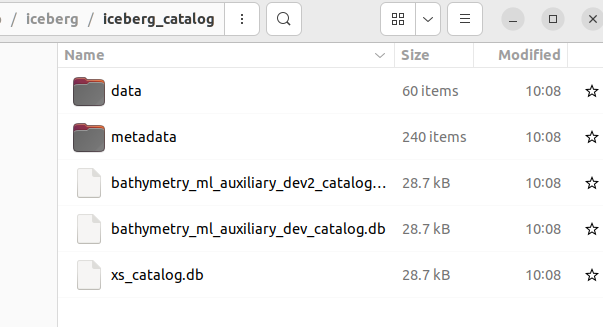